#### Session-Stopper

In [ ]:
import time
for i in range(50):
  print('Stop: ', i)
  time.sleep(30*60)

-----

In [22]:
!pip install -q pymap3d

In [335]:
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import random
import numpy as np
from math import atan2, asin
import pandas as pd
from IPython.display import display
from pprint import pprint
from PIL import Image
import datetime
import time
import sys
from pymap3d import geodetic2enu, enu2geodetic
import warnings
warnings.filterwarnings('ignore')

image_size = (1920, 1200)
fx, fy, cx, cy = [718.8560, 718.8560, 607.1928, 185.2157]
camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

In [1]:
!unzip -q /content/optical-edge-dev.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


------

In [4]:
!unzip -q sample-dataset-xs.zip

In [304]:
# sys.path.append('/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/optical-edge-dev')
sys.path.append(r'C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\optical-edge-dev')

import pose_est
from pose_est import *
import vo
from vo import Stitcher
from vo import FeatureLocalization

In [305]:
# sys.path.append('/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/py_files')
sys.path.append(r'C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\py_files')

import Utils
from Utils import *

In [25]:
import importlib
importlib.reload(vo)
importlib.reload(Utils)

<module 'Utils' from '/home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/py_files/Utils.py'>

In [336]:
# sample_dataset_dir = r"/home/datademon/Desktop/Data/cam"
# sample_dataset_dir = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\sfm-files\thaiyur-E333-50"
sample_dataset_dir = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\opensfm-main\OpenSfM\data\thaiyur-E249-40"

# keyword = 'str'
sample_dir = [nm for nm in os.listdir(os.path.join(sample_dataset_dir, 'images')) if (nm.endswith('.jpg') or nm.endswith('.tiff'))]
print(len(sample_dir))
sample_dataset_path = sample_dir 
print(sample_dir[:3])

40
['img_E249_867579613533_1679940515_30898803.jpg', 'img_E249_867912898968_1679940515_364113525.jpg', 'img_E249_868246188426_1679940515_697333911.jpg']


In [337]:
choice = 0
print('Strip-Selected: ', sample_parent_dir[choice])
sample_dataset_path = os.path.join(sample_dataset_dir, sample_parent_dir[choice])
mid_dir = sample_parent_dir[choice].split('_')[1]
save_parent_dir = f"/home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/Ouputs/{mid_dir}"
if not os.path.isdir(save_parent_dir):
  os.mkdir(save_parent_dir)
save_file_name = f'{save_parent_dir}/flight_parameters_estimation_{sample_parent_dir[choice]}.csv'
print('Save-Path: ', save_file_name)

sample_dir = os.listdir(sample_dataset_path)
sample_dir = [path for path in sample_dir if path.endswith('.tiff')]
print('No. of Samples: ', len(sample_dir))


def key_fn(item):
  return item.split('_')[2]

sample_dir = sorted(sample_dir, key=key_fn, reverse=False)
print(sample_dir[:2])

NameError: name 'sample_parent_dir' is not defined

##### Arranging frame sequence w.r.t logging parameter (NOT Jetson Time)

In [338]:
# sample_dir = os.listdir(sample_dataset_path)
# sample_dir = [path for path in sample_dir if path.endswith('.tiff')]

# def key_fn(item):
#   return item.split('_')[2]

# sample_dir = sorted(sample_dir, key=key_fn, reverse=False)

''' Taking only n=50 samples for stitching '''
num_take = 100
sample_dir = sample_dir[:num_take] 

print('No. of Samples: ', len(sample_dir))
print(sample_dir[:2])

No. of Samples:  40
['img_E249_867579613533_1679940515_30898803.jpg', 'img_E249_867912898968_1679940515_364113525.jpg']


In [339]:
timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in sample_dir]
utc_timestamps_list = list(map(jetson_timestamp_to_utc, timestamps_list))

print(timestamps_list)
print(utc_timestamps_list)

flight_obj = {}
rev_flight_obj = {}

for time, path in zip(utc_timestamps_list, sample_dir):
  flight_obj[time] = path
  rev_flight_obj[path] = time

print()
print('Time-Wise Path Storages -')
print()
# pprint(flight_obj)

['1679940515_3089880', '1679940515_36411352', '1679940515_69733391', '1679940516_3080847', '1679940516_36406595', '1679940516_69726691', '1679940517_3052048', '1679940517_36381792', '1679940517_69708337', '1679940518_3036062', '1679940518_36329066', '1679940518_69650689', '1679940519_2978571', '1679940519_36312149', '1679940519_69633470', '1679940520_2970085', '1679940520_36301551', '1679940520_69635731', '1679940521_2951747', '1679940521_36278250', '1679940521_69610173', '1679940522_2952311', '1679940522_36273899', '1679940522_69593025', '1679940523_2924485', '1679940523_36250386', '1679940523_69587484', '1679940524_2908207', '1679940524_36247753', '1679940524_69561869', '1679940525_2893952', '1679940525_36222516', '1679940525_69554007', '1679940526_2889358', '1679940526_36208763', '1679940526_69563753', '1679940527_2857631', '1679940527_36199459', '1679940527_69524960', '1679940528_2851846']
['2023-03-27 23:38:35.003090', '2023-03-27 23:38:35.036411', '2023-03-27 23:38:35.069733', '2


Time-Wise Path Storages -



In [340]:
rn_ent = random.randint(0, len(sample_dir) - 2)
print('Random-ENT: ', rn_ent)

# target_size = (256, 256)

print(f't = {rev_flight_obj[sample_dir[rn_ent]]} --> {sample_dir[rn_ent]} UTC , t = {rev_flight_obj[sample_dir[rn_ent + 1]]} --> {sample_dir[rn_ent + 1]} UTC')
sample_first_path, sample_second_path = os.path.join(sample_dataset_path, sample_dir[rn_ent]), os.path.join(sample_dataset_path, sample_dir[rn_ent + 1])
sample_first_frame, sample_second_frame = Image.open(sample_first_path), Image.open(sample_second_path)
sample_first_frame, sample_second_frame = np.asarray(sample_first_frame), np.asarray(sample_second_frame)
# sample_first_frame, sample_second_frame = cv2.resize(sample_first_frame, target_size), cv2.resize(sample_second_frame, target_size)

print(sample_first_frame.shape, sample_second_frame.shape)
fig, axs = plt.subplots(1, 2, figsize = (10, 10))

axs[0].imshow(sample_first_frame)
axs[0].set_title(f't = {rev_flight_obj[sample_dir[rn_ent]]} UTC')

axs[1].imshow(sample_second_frame)
axs[1].set_title(f't = {rev_flight_obj[sample_dir[rn_ent + 1]]} UTC')

plt.show()

Random-ENT:  15
t = 2023-03-27 23:38:40.002970 --> img_E249_872578947384_1679940520_29700856.jpg UTC , t = 2023-03-27 23:38:40.036302 --> img_E249_872912240892_1679940520_363015516.jpg UTC


TypeError: expected str, bytes or os.PathLike object, not list

### Optical-Stitching

In [341]:
print(sample_dir)
resized_frames = np.array([cv2.resize(cv2.imread(os.path.join(os.path.join(sample_dataset_dir, 'images'), nm)), image_size) for nm in sample_dir])
print(resized_frames.shape)

['img_E249_867579613533_1679940515_30898803.jpg', 'img_E249_867912898968_1679940515_364113525.jpg', 'img_E249_868246188426_1679940515_697333911.jpg', 'img_E249_868579477884_1679940516_30808478.jpg', 'img_E249_868912771392_1679940516_364065953.jpg', 'img_E249_869246060850_1679940516_697266914.jpg', 'img_E249_869579350308_1679940517_30520484.jpg', 'img_E249_869912634663_1679940517_363817928.jpg', 'img_E249_870245922231_1679940517_697083371.jpg', 'img_E249_870579211689_1679940518_30360622.jpg', 'img_E249_870912498987_1679940518_363290665.jpg', 'img_E249_871245786582_1679940518_696506890.jpg', 'img_E249_871579076040_1679940519_29785710.jpg', 'img_E249_871912368468_1679940519_363121490.jpg', 'img_E249_872245657926_1679940519_696334707.jpg', 'img_E249_872578947384_1679940520_29700856.jpg', 'img_E249_872912240892_1679940520_363015516.jpg', 'img_E249_873245530350_1679940520_696357313.jpg', 'img_E249_873578819808_1679940521_29517473.jpg', 'img_E249_873912109266_1679940521_362782500.jpg', 'img_E

In [17]:
import time

num_frames = len(resized_frames)
# num_frames = 5

print('Num-Frames: ', num_frames)
detector = "SIFT"
matcher = "BF"
threshold = 0.75
trajMap = np.zeros((*image_size, 3), dtype=np.uint8)
out_pose_file = 'traj_est.txt'


ft = time.time()
for i in tqdm((range(num_frames)), desc="Stitching frames", unit="frame"):

    if i == 0:
        result_img = resized_frames[i]
        curr_R = np.eye(3)
        curr_t = np.array([0, 0, 0]).astype('float64')

    else:
        Image1 = result_img
        Image2 = resized_frames[i]

        # Checking if images read
        if Image1 is None or Image2 is None:
            print("\nImages not read properly or does not exist.\n")
            exit(0)

        # Calling function for stitching images.

        eae = EAE(Image2, Image1)
        _, t, euler_angle_rad, _ = eae.run(is_store = True)
        euler_angle = [euler_angle_rad['roll'], euler_angle_rad['pitch'], euler_angle_rad['yaw']]
        R = euler_angles_to_rotation_matrix(euler_angle)
        result_img = stitch_frames(Image2, Image1, curr_R, curr_t)

        ''' For Comparison '''

        # stitcher = Stitcher(Image2, Image1, detector, matcher, threshold)
        # _, R_temp, _ = stitcher.stitch_frames(curr_R, curr_t, fx, cx, cy)

        # # print('R: ', R)
        # # print()
        # # print('R_temp: ', R_temp)
        # print('Diff: ', abs(R - R_temp))
        # print()

        if i == 1:
          curr_R = R
          curr_t = t

        else:
          curr_R = np.matmul(prev_R, R)
          curr_t = (np.matmul(prev_R, t)) + (prev_t)

        prev_R = curr_R
        prev_t = abs(curr_t)

    pass

lt = time.time()

print('Execution-time (UNIX): ', (lt - ft))

fig, axs = plt.subplots(1, 1, figsize = (12, 12))

result_img = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)
# result_img = cv2.resize(result_img, image_size)

axs.imshow(result_img)
axs.set_title('Optical-Frame-Stitched-Image')

plt.axis('off')
plt.show()

Num-Frames:  20


Stitching frames:   0%|          | 0/20 [00:00<?, ?frame/s]

Stitching frames:   5%|▌         | 1/20 [00:15<04:45, 15.00s/frame]


NameError: name 'stitch_frames' is not defined

#### Different-Display

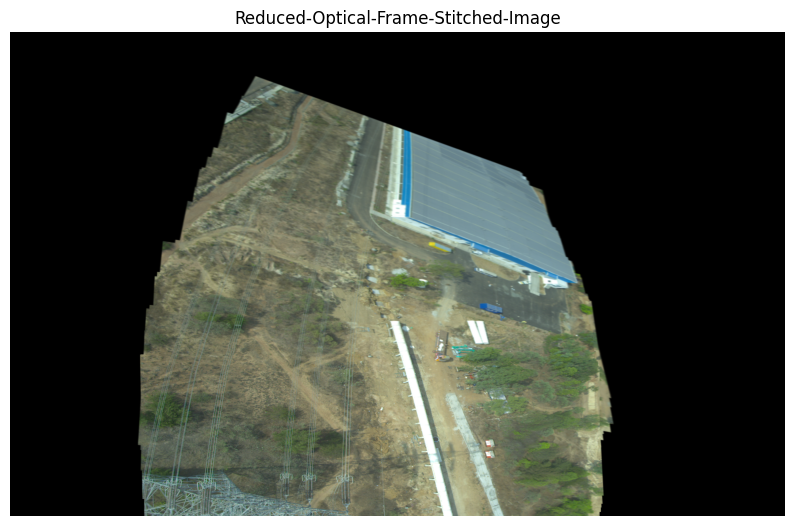

In [112]:
image_size = (1920, 1200)

fig, axs = plt.subplots(1, 1, figsize = (10, 10))

axs.imshow(cv2.resize(result_img, image_size))
axs.set_title('Reduced-Optical-Frame-Stitched-Image')

plt.axis('off')
plt.show()

In [113]:
import tifffile

tifffile.imwrite(f'/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/stitched_img_{sample_parent_dir[choice]}_for_{num_frames}_frames.tiff', result_img)

### INS Data Retrival and Frame Matching
There's a precision problem (in Jetson-Time) when trying to load the CSV file

In [342]:
flight_num = 'E249'

In [343]:
# combine_ins_path_all = f"./INS_Data/{flight_num}/ins/combine_ins_{flight_num}_1679939656_time"
# combine_ins_path_all = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\INS_Data\E319\ins\combine_ins_E319_1679939656_time.csv"
# combine_ins_path_all = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\INS_Data\E333\ins\combine_ins_E333_1691740435.csv"
# combine_ins_path_all = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\INS_Data\E321\ins\combine_ins_E322_1679939656_time.csv"
combine_ins_path_all = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\INS_Data\E240\ins\combine_ins_E240_1679939655_time.csv"
# combine_ins_path_all = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\INS_Data\E243\ins\combine_ins_E243_1679939672_time.csv"
combine_ins_path_all = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\INS_Data\E249\ins\combine_ins_E249_1679939656_time.csv"

# combine_ins_path_time = f"./INS_Data/{flight_num}/ins/ins_{flight_num}_1679939656_time"
# combine_ins_path_time = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\INS_Data\E333\ins\ins_E333_1691740435.csv"
# combine_ins_path_time = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\INS_Data\E243\ins\ins_E243_1679939672_time.csv"
# combine_ins_path_time = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\INS_Data\E321\ins\ins_E322_1679939656_time.csv"
# combine_ins_path_time = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\INS_Data\E240\ins\ins_E240_1679939655_time.csv"
combine_ins_path_time = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\INS_Data\E249\ins\ins_E249_1679939656_time.csv"
# combine_ins_path_time = r"C:\Users\Alik\Desktop\Drop_Year\Galaxeye\Files\store-room\optical-edge-flight-param-main-v3\INS_Data\E319\ins\ins_E319_1679939656_time.csv"

dtypes = {' Jetson Time': np.float64}
df_ins_data_time = pd.read_csv(combine_ins_path_time, float_precision='high', dtype=dtypes)
df_ins_data_all = pd.read_csv(combine_ins_path_all)

display(df_ins_data_time.head(3))
display(df_ins_data_all.head(3))
df_ins_data_time[' Jetson Time'][0]

,Packet Count,Jetson Time
0,0,1.679940e+09
1,1,1.679940e+09
2,2,1.679940e+09


,Packet Count,UTC Time,Acc_SensorX,Acc_SensorY,Acc_SensorZ,Gyr_SensorX,Gyr_SensorY,Gyr_SensorZ,Mag_SensorX,Mag_SensorY,...,RawAccZ,SampleTimeFine,LatitudeRaw,LongitudeRaw,Height,HeightMSL,nanoseconds,Pressure,Packet Countextra,Jetson Time
0,0,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,407364,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.679940e+09
1,1,33,-0.33,0.3,9.8,-0.02,0.0,0.0,-0.6,-0.39,...,NaN,407464,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.679940e+09
2,2,33,-0.33,0.3,9.8,-0.02,0.0,0.0,-0.6,-0.39,...,NaN,407564,NaN,NaN,NaN,NaN,NaN,101156.0,2.0,1.679940e+09


1679939655.8286555

In [313]:
j_col = df_ins_data_time.columns[-1]
p_col = df_ins_data_time.columns[0]

print('Columns of Interest: ', j_col, ', ', p_col)

Columns of Interest:   Jetson Time ,  Packet Count


In [314]:
ins_jetson = list(df_ins_data_time[j_col].dropna())
ins_jetson = [str(time).split('.')[0] + '_' + '0' for time in ins_jetson]
utc_ins_jetson = list(map(jetson_timestamp_to_utc, ins_jetson))
ins_flight_obj = {}
for unix_time, utc_time in zip(ins_jetson, utc_ins_jetson):
  ins_flight_obj[utc_time] = unix_time

### Euler Angle Estimation

In [315]:
print(type(rev_flight_obj))
df_data = [df_ins_data_time, df_ins_data_all]

<class 'dict'>


In [316]:
## Rotation Order - X, Y, Z (Roll, Pitch, Yaw)
sample_timestamp = sample_dir[0]
print(sample_timestamp)
ins_euler_angle = closest_ea(sample_timestamp, rev_flight_obj, df_data, want_prev=False)

## ( 0-th - 1 ) frame
prev_ins_euler_angle = closest_ea(sample_timestamp, rev_flight_obj, df_data, want_prev=True)

print('prev_ins_euler_angle: ', prev_ins_euler_angle)

img_E240_360566645427_1679940008_58138883.jpg
prev_ins_euler_angle:  [-1.82, 9.03, -74.97]


In [317]:
pred_ins_euler_angle = [(prev_ea + delta_ea) for delta_ea, prev_ea in zip(list(euler_angle_rad.values()), prev_ins_euler_angle)]

print('OPTICAL-FRAME-EST. -> ')
print(f'ROLL (in rad) : {pred_ins_euler_angle[0]:.2f}, PITCH (in rad) : {pred_ins_euler_angle[1]:.2f}, YAW (in rad) : {pred_ins_euler_angle[-1]:.2f}')
print()
print('INS (IMU) Value -> ')
print(f'ROLL (in rad) : {ins_euler_angle[0]}, PITCH (in rad) : {ins_euler_angle[1]}, YAW (in rad) : {ins_euler_angle[-1]}')

NameError: name 'euler_angle_rad' is not defined

### (Consecutive Flight-Parameter Estimation)
We will estimate consecutive 5-frame flight-parameters and compare with INS sensor parameter values

##### Alternate 1: Sourcing the ( R , t ) values directly from OPT-file (reconstructions.json) 

In [318]:
import json

json_file = os.path.join(sample_dataset_dir, "reconstruction.json")

In [320]:
def extract_parameters(json_file):
    # Load JSON data from file
    with open(json_file, 'r') as file:
        data = json.load(file)[0]

    # Extract focal, k1, k2 from cameras
    camera_params = {}
    for camera_id, camera_info in data['cameras'].items():
        camera_params[camera_id] = {
            'focal': camera_info['focal'],
            'k1': camera_info['k1'],
            'k2': camera_info['k2']
        }

    # Extract rotation (R) and translation (T) from shots
    shot_params = {}
    for shot_id, shot_info in data['shots'].items():
        shot_params[shot_id] = {
            'R': shot_info['rotation'],
            'T': shot_info['translation']
        }

    return camera_params, shot_params

# Extract parameters
camera_params, shot_params = extract_parameters(json_file)

# Print extracted parameters
print("Camera Parameters:")
for camera_id, params in camera_params.items():
    print(f"Camera ID: {camera_id}")
    print(f"  Focal: {params['focal']}")
    print(f"  k1: {params['k1']}")
    print(f"  k2: {params['k2']}")

# k1, k2, focal_len = 

print("\nShot Parameters:")
for shot_id, params in shot_params.items():
    print(f"Shot ID: {shot_id}")
    print(f"  Rotation (R): {params['R']}")
    print(f"  Translation (T): {params['T']}")

int_params = list(list(camera_params.items())[-1])[-1]
focal, k1, k2 = int_params['focal'], int_params['k1'], int_params['k2']
print()
print('Focal: ', focal, ', k1: ', k1, ', k2: ', k2)
print()

frame_ids = [frame_id for frame_id, params in shot_params.items()]

def key_fn(item):
    return item.split('_')[2]

frame_ids = sorted(frame_ids, key = key_fn, reverse = False)

print('Frame_ID: ')
print(frame_ids)


Camera Parameters:
Camera ID: v2 unknown unknown 1920 1200 perspective 0.0
  Focal: 1.017226030353333
  k1: -0.14560004499906143
  k2: 0.09972576720350855

Shot Parameters:
Shot ID: img_E240_360900654894_1679940008_391646443.jpg
  Rotation (R): [-0.16248466233619713, -1.8663464505503642, 0.35605785091639713]
  Translation (T): [-6.760773299534128, 98.14209224156451, -18.117577915114094]
Shot ID: img_E240_361234207251_1679940008_724268128.jpg
  Rotation (R): [-0.13230546168365903, -1.8980408632895154, 0.35825495346360675]
  Translation (T): [-8.234682402202392, 93.192079293248, -15.735855919837565]
Shot ID: img_E240_361900944036_1679940009_391413395.jpg
  Rotation (R): [-0.15136708662046883, -1.8993580089814504, 0.36442645367869525]
  Translation (T): [-6.165246276871237, 83.01864126394376, -15.011832103649361]
Shot ID: img_E240_362234244537_1679940009_724752151.jpg
  Rotation (R): [-0.1486691862880644, -1.8982067543353207, 0.3531965295411165]
  Translation (T): [-5.345927927450938, 78.

In [321]:
init_timestamp = sample_dir[0]
init_euler_angle = closest_ea(init_timestamp, rev_flight_obj, df_data, want_prev = False)

print('Init-Flight-Parameters: ', init_euler_angle)

Init-Flight-Parameters:  [-1.84, 8.94, -74.95]


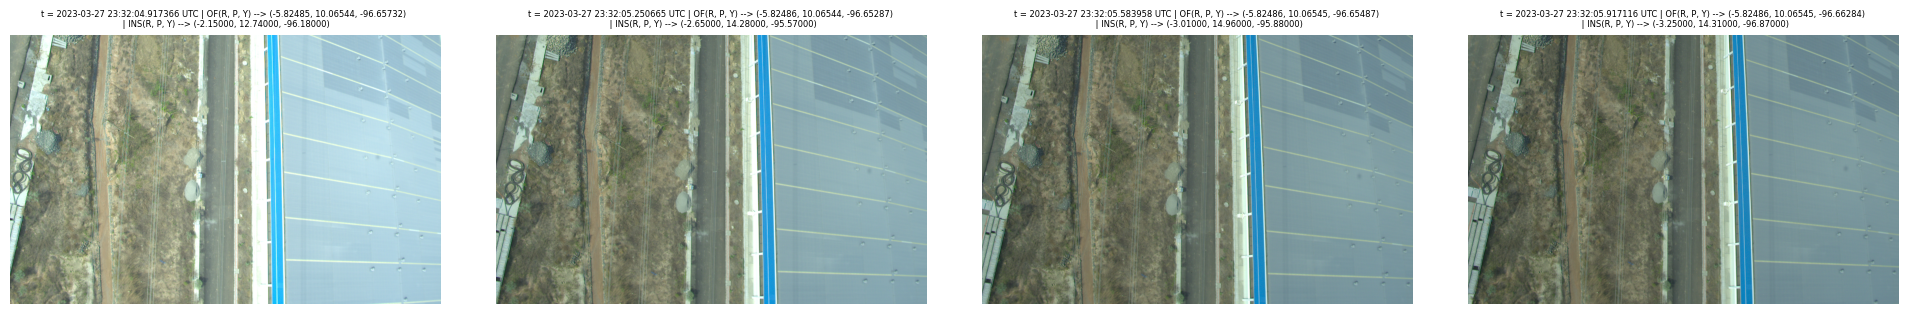

Execution-Time (UNIX):  2.796786069869995


In [156]:
import time

num_frames = 4#5
fig, axs = plt.subplots(1, num_frames, figsize = (20, 20))

ini_frame_path = os.path.join(sample_dataset_path, sample_dir[0])
ini_frame = np.asarray(Image.open(ini_frame_path))

ft = time.time()
for i in range(num_frames):

  next_frame_path = os.path.join(sample_dataset_path, sample_dir[i + 1])
  next_frame = np.asarray(Image.open(next_frame_path))

  eae = EAE(next_frame, ini_frame)
  euler_angle_rad, euler_angle_deg = eae.run()

  pred_ins_euler_angle = [(prev_ea + delta_ea) for delta_ea, prev_ea in zip(list(euler_angle_rad.values()), init_euler_angle)]
  ins_euler_angle = closest_ea(sample_dir[i + 1], rev_flight_obj, df_data, want_prev = False)

  axs[i].imshow(next_frame)
  axs[i].set_title(f't = {rev_flight_obj[sample_dir[i+1]]} UTC | OF(R, P, Y) --> ({pred_ins_euler_angle[0]:.5f}, {pred_ins_euler_angle[1]:.5f}, {pred_ins_euler_angle[-1]:.5f}) \n | INS(R, P, Y) --> ({ins_euler_angle[0]:.5f}, {ins_euler_angle[1]:.5f}, {ins_euler_angle[-1]:.5f})', fontsize = 6)
  axs[i].axis('off')

  ini_frame = next_frame
  init_euler_angle = pred_ins_euler_angle

plt.tight_layout(pad = 4)
plt.show()

lt = time.time()

print('Execution-Time (UNIX): ', (lt - ft))

In [322]:
import numpy as np

sensor_width = 29.3  # mm
sensor_height = 29  # mm

image_width = 1920  # in pixels
image_height = 1200  # in pixels

pixel_size_x = sensor_width / image_width
pixel_size_y = sensor_height / image_height

scale_factor_x = pixel_size_x / fx  # m/pixel
scale_factor_y = pixel_size_y / fy  # m/pixel

scale_factor = (scale_factor_x + scale_factor_y) / 2

print('Scale-Factor: ', scale_factor)

Scale-Factor:  2.7423491862997134e-05


### Flight-Parameter Data-Saving (CSV) | [Unix-Timestamp, Roll, Pitch, Yaw, Lat, Lon, Alt]

In [323]:
num_frames = len(sample_dir)
print('total no. of frames:', num_frames, ', selected no. of frames: ', len(frame_ids))

total no. of frames: 40 , selected no. of frames:  40


when running through OpenSfM, things are different as they don't use all images = frame_ids

In [324]:
# timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in sample_dir]
timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in frame_ids]
utc_timestamps_list = list(map(jetson_timestamp_to_utc, timestamps_list))

flight_obj = {}
rev_flight_obj = {}

for time, path in zip(utc_timestamps_list, frame_ids):
  flight_obj[time] = path
  rev_flight_obj[path] = time

# unix_timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in sample_dir]
unix_timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in frame_ids]

unix_timestamps_list = list(map(get_unix_timestamps, timestamps_list))

print()
print('Timestamps: ', unix_timestamps_list[:3], ', Timestamps-size: ', len(unix_timestamps_list))


Timestamps:  [1679940008.005814, 1679940008.039165, 1679940008.072427] , Timestamps-size:  40


In [325]:
import math

def calc_euler_angle(rot_matrix):

    r11, r12, r13 = rot_matrix[0]
    r21, r22, r23 = rot_matrix[1]
    r31, r32, r33 = rot_matrix[2]

    # Calculate pitch angle
    pitch = -asin(r31)

    # Calculate roll angle
    cos_pitch = np.cos(pitch)
    if abs(cos_pitch) > 1e-8:  # Prevent division by zero
        roll = atan2(r32, r33)
    else:
        roll = atan2(r21, r11)

    # Calculate yaw angle
    sec_pitch = 1.0 / cos_pitch
    yaw = atan2(r21 * sec_pitch, r11 * sec_pitch)

    return roll, pitch, yaw

	
# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6
 
# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
    assert(isRotationMatrix(R))
 
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
 
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return [x, y, z]

In [326]:
import time

# initial_frame_timestamp = sample_dir[0]
initial_frame_timestamp = frame_ids[0]

print('initial_frame_timestamp: ', initial_frame_timestamp)

# ref_coordinates = [12.9, 80.2, 6.7]
ini_ea = closest_ea(initial_frame_timestamp, rev_flight_obj, df_data)
ini_coordinates = closest_t(initial_frame_timestamp, rev_flight_obj, df_data)

# ini_frame_path = os.path.join(sample_dataset_path, sample_dir[0])
# ini_frame = np.asarray(Image.open(ini_frame_path))

df_OF_cols = ['Timestamps', 'Roll_N', 'Pitch_E', 'Yaw_U']#, 'Latitude', 'Longitude', 'Altitude']
roll_list, pitch_list, yaw_list, lat_list, lon_list, alt_list = [], [], [], [], [], []

ft = time.time()

for i in tqdm(range(len(frame_ids)), desc="Processing frames", unit="frame"):

  roll_list.append(ini_ea[0])
  pitch_list.append(ini_ea[1])
  yaw_list.append(ini_ea[-1])

  # lat_list.append(ini_coordinates[0])
  # lon_list.append(ini_coordinates[1])
  # alt_list.append(ini_coordinates[-1])

  # if (i + 1) >= num_frames:
  #   break

  # next_frame_path = os.path.join(sample_dataset_path, sample_dir[i + 1])
  # next_frame = np.asarray(Image.open(next_frame_path))

  # eae = EAE(next_frame, ini_frame)
  # one_frame_R, one_frame_t, euler_angle_rad, _ = eae.run(is_store = True)

  one_frame_R, one_frame_t = np.array(shot_params[frame_ids[i]]['R']).reshape(3, 1), np.array(shot_params[frame_ids[i]]['T']).reshape(3, 1)
  one_frame_R, _ = cv2.Rodrigues(one_frame_R)
  # euler_angle = list(calc_euler_angle(one_frame_R))
  euler_angle = list(rotationMatrixToEulerAngles(one_frame_R)) 

  # pred_ins_euler_angle = [(prev_ea + delta_ea) for delta_ea, prev_ea in zip(list(euler_angle.values()), ini_ea)]
  pred_ins_euler_angle = [(prev_ea + delta_ea) for delta_ea, prev_ea in zip(euler_angle, ini_ea)]
  
  # lat, lon, alt = trans_vec_to_lla(one_frame_t, one_frame_R, scale_factor, ini_ea, ini_coordinates)

  # ini_frame = next_frame
  ini_ea = pred_ins_euler_angle
  # ini_coordinates = [lat, lon, alt]
  pass 

df_of = pd.DataFrame(columns = df_OF_cols)

data = {
    'Timestamps': unix_timestamps_list,
    'Roll_N': roll_list,
    'Pitch_E': pitch_list,
    'Yaw_U': yaw_list
    }
    # 'Latitude': lat_list,
    # 'Longitude': lon_list,
    # 'Altitude': alt_list
# }

df_of = pd.DataFrame(data)
display(df_of.head(3))

lt = time.time()

print('Execution-time (UNIX): ', (lt - ft))

initial_frame_timestamp:  img_E240_360566645427_1679940008_58138883.jpg


Processing frames: 100%|██████████| 40/40 [00:00<00:00, 2472.15frame/s]


,Timestamps,Roll_N,Pitch_E,Yaw_U
0,1.679940e+09,-1.840000,8.940000,-74.950000
1,1.679940e+09,-4.083038,7.809311,-72.607450
2,1.679940e+09,-6.373474,6.683123,-70.196929


Execution-time (UNIX):  0.050597429275512695


In [136]:
df_of.to_csv('optical_frame_parameters_strip_E319.csv', index=False)

### Euler Angle Trend Comparision (Optical Frames and INS)

In [328]:
ins_ea = [closest_ea(timestamp, rev_flight_obj, df_data) for timestamp in frame_ids]
ins_unix_timestamps_list = [closest_ea(timestamp, rev_flight_obj, df_data, want_timestamp=True)[-1] for timestamp in frame_ids]

print('--- INS ---')
print()
pprint(ins_unix_timestamps_list[:10])
print()
print('--- OF ---')
print()
pprint(unix_timestamps_list[:10])
print()
print('No. of Frames: ', len(ins_unix_timestamps_list))

ins_roll_N = [r for r, p, y in ins_ea]
ins_pitch_E = [p for r, p, y in ins_ea]
ins_yaw_U = [y for r, p, y in ins_ea]

--- INS ---

[1679940007.9942334,
 1679940007.9942334,
 1679940008.1228633,
 1679940008.9944613,
 1679940008.9944613,
 1679940009.121998,
 1679940009.9937067,
 1679940009.9937067,
 1679940010.1025789,
 1679940010.9803798]

--- OF ---

[1679940008.005814,
 1679940008.039165,
 1679940008.072427,
 1679940009.005802,
 1679940009.039141,
 1679940009.072475,
 1679940010.005787,
 1679940010.039138,
 1679940010.072467,
 1679940011.006213]

No. of Frames:  40


In [329]:
of_pitch_E = list(df_of.Pitch_E)
of_roll_N = list(df_of.Roll_N)
of_yaw_U = list(df_of.Yaw_U)

print('OF-pitch-E: ', of_pitch_E[:10])
print('OF-roll-N: ', of_roll_N[:10])
print('OF-yaw-U: ', of_yaw_U[:10])

OF-pitch-E:  [8.94, 7.809310531667964, 6.683123235477456, 5.566764343885983, 4.464944542100407, 3.360535246252723, 2.2489683592479492, 1.132273490764817, 0.01861157919563805, -1.0905106565592677]
OF-roll-N:  [-1.84, -4.083037792137802, -6.373473941831509, -8.730811385715848, -11.0934736518586, -13.433488144285215, -15.78654802310654, -18.164024982537562, -20.55852811710926, -22.971097348137842]
OF-yaw-U:  [-74.95, -72.60745041269776, -70.19692863811093, -67.69993057274841, -65.19794356127474, -62.72615041572011, -60.2466283142858, -57.74571087854162, -55.227820260784085, -52.691153045631026]


In [330]:
def is_nan_list(x):
    return math.isnan(x)


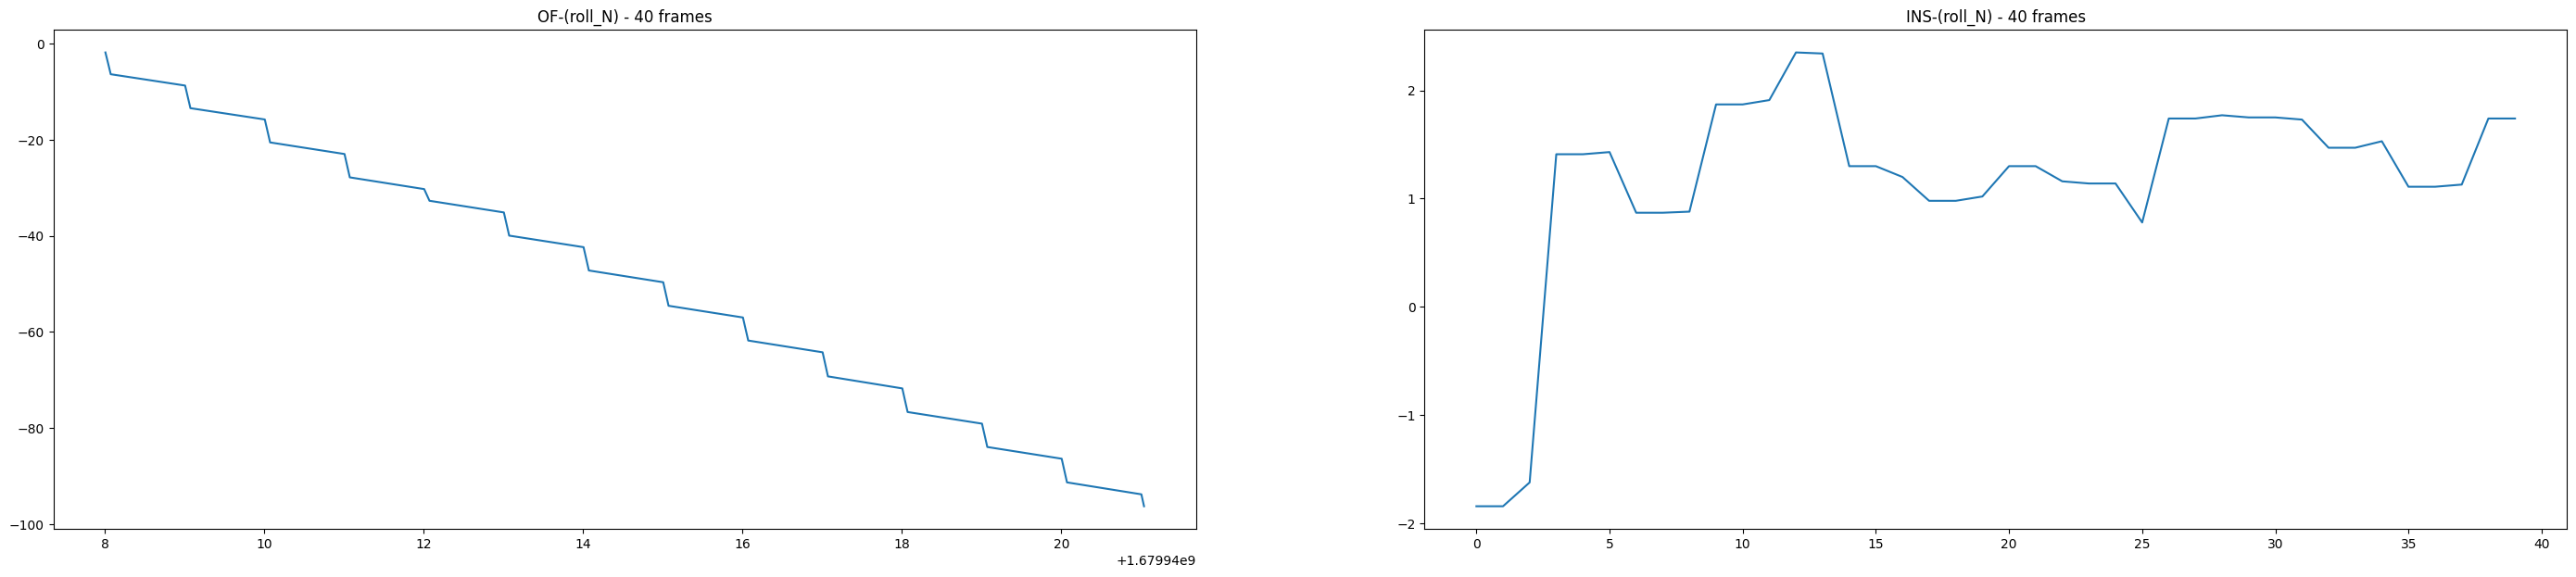

Mean (OF/INS):  -48.60406359089583 ,  1.1822500000000002


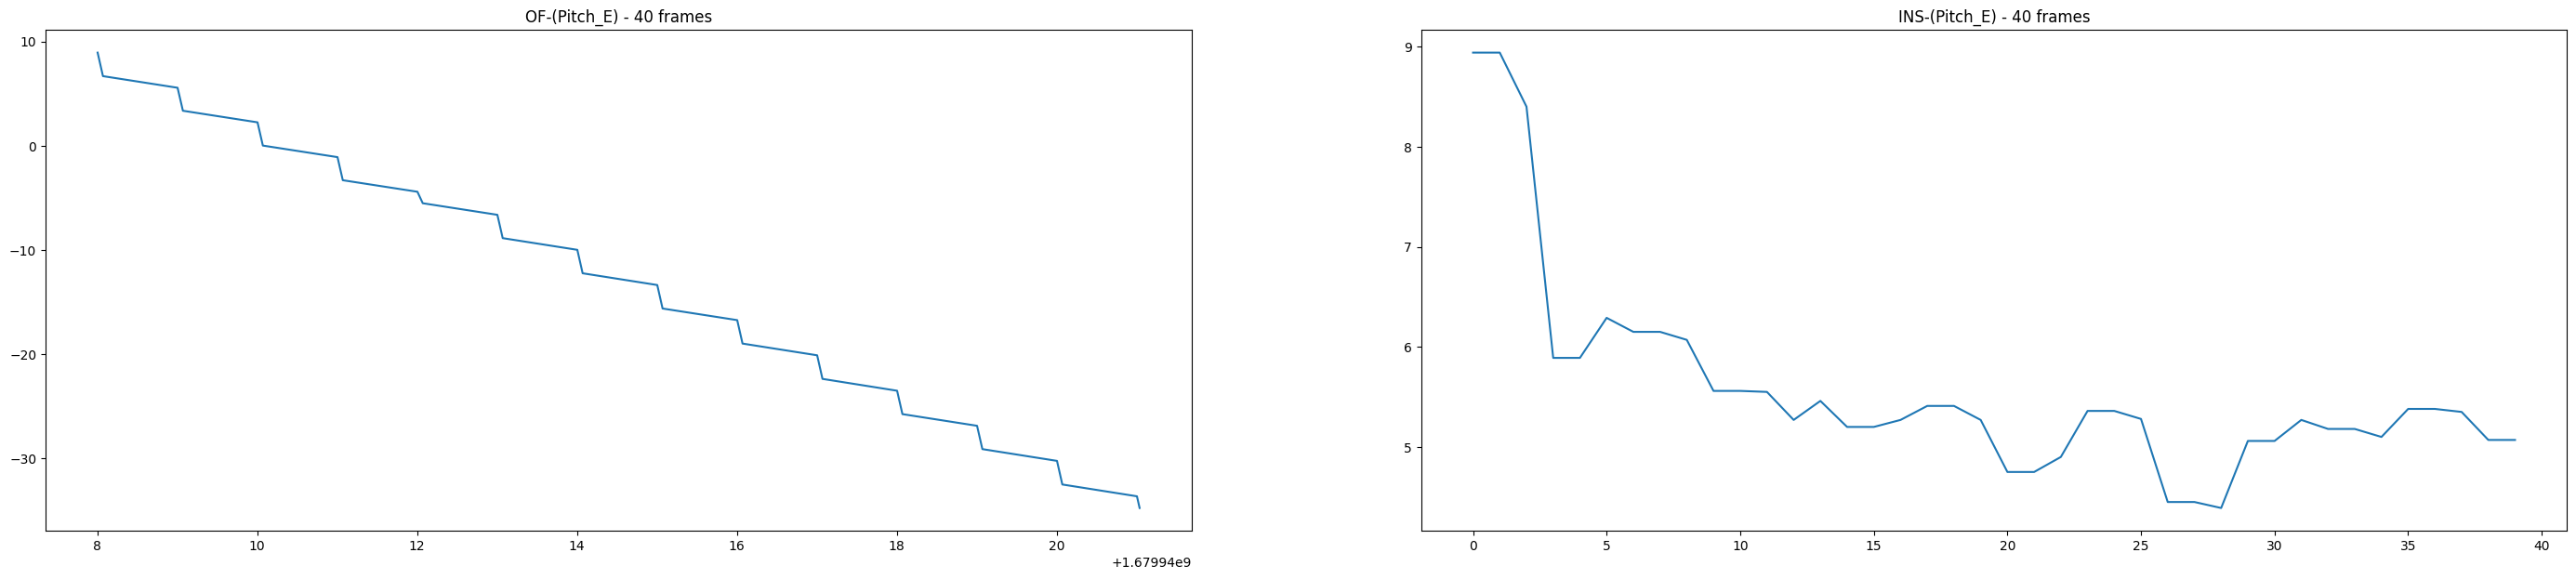

Mean (OF/INS):  -12.85067736038431 ,  5.566750000000001


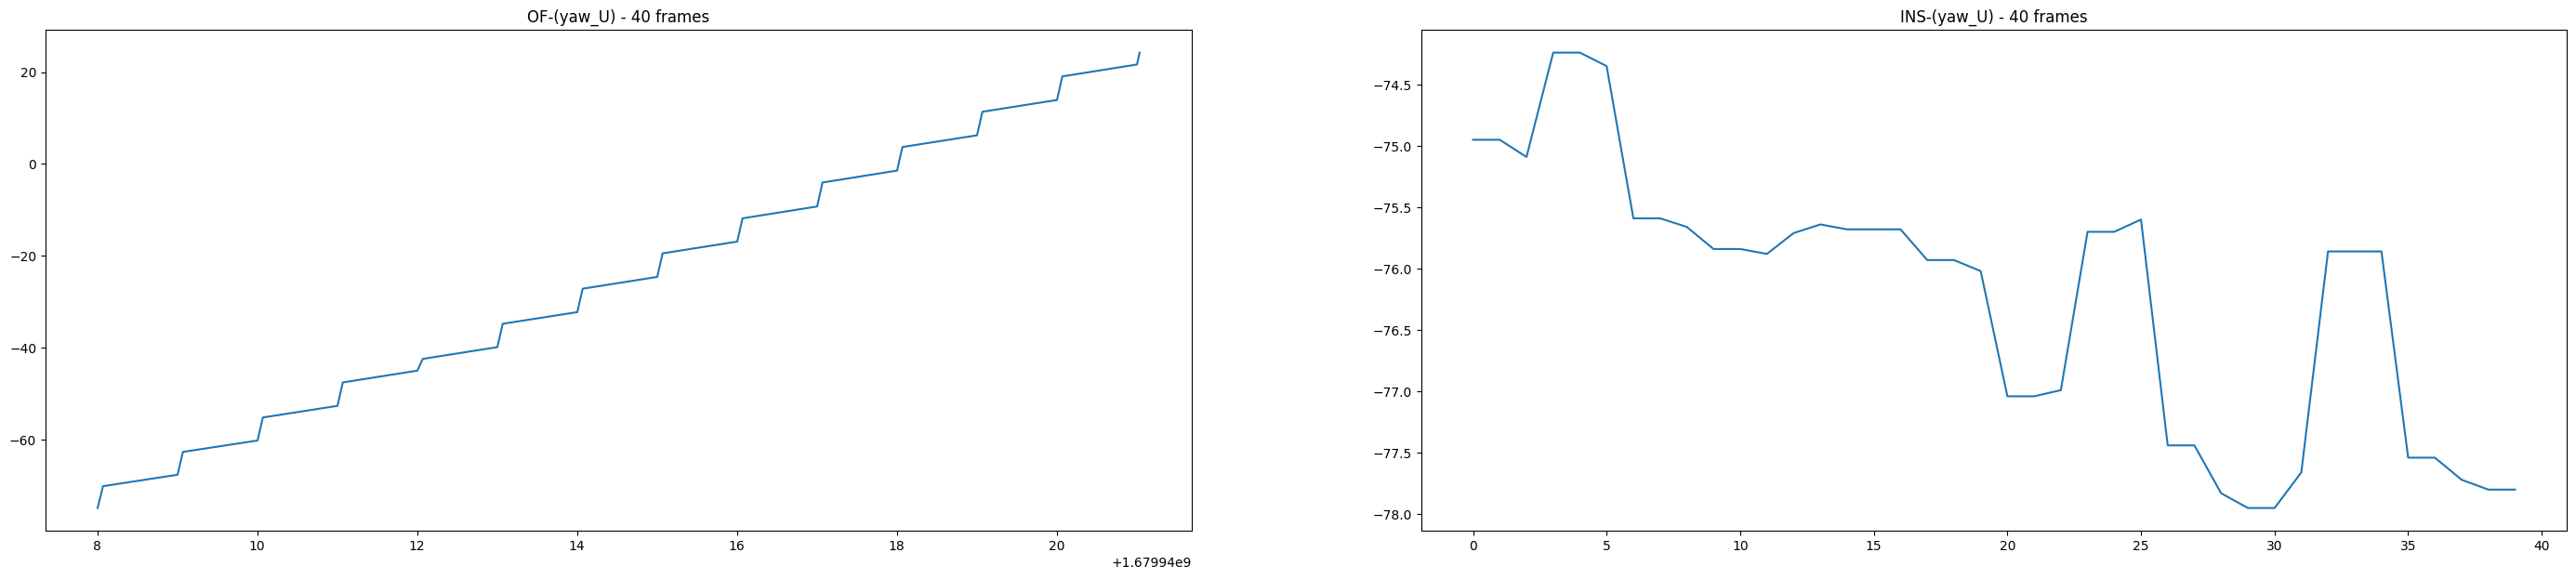

Mean (OF/INS):  -25.736152762603524 ,  -76.22025


In [331]:
fig, axs = plt.subplots(1, 2, figsize = (35, 7))

xtick_labels_of = [f"{value:.3f}" for value in [0] + unix_timestamps_list]
xtick_labels_ins = [f"{value:.3f}" for value in [0] + ins_unix_timestamps_list]

ytick_labels = [f"{value:.10f}" for value in [0] + of_roll_N]  # Format with 15 decimal places
axs[0].plot(unix_timestamps_list, of_roll_N)
# axs[0].set_yticklabels(ytick_labels)
# axs[0].set_xticklabels(xtick_labels_of)
axs[0].set_title(f'OF-(roll_N) - {num_frames} frames')

axs[1].plot(ins_roll_N)
axs[1].set_title(f'INS-(roll_N) - {num_frames} frames')
# axs[1].set_xticklabels(xtick_labels_ins)

plt.show()

print('Mean (OF/INS): ', np.mean(np.array(of_roll_N)), ', ', np.mean(np.array([k for k in ins_roll_N if not is_nan_list(k)])))

fig, axs = plt.subplots(1, 2, figsize = (35, 7))

ytick_labels = [f"{value:.10f}" for value in [0] + of_pitch_E]  # Format with 15 decimal places

axs[0].plot(unix_timestamps_list, of_pitch_E)
# axs[0].set_yticklabels(ytick_labels)
# axs[0].set_xticklabels(xtick_labels_of)
axs[0].set_title(f'OF-(Pitch_E) - {num_frames} frames')

axs[1].plot(ins_pitch_E)
axs[1].set_title(f'INS-(Pitch_E) - {num_frames} frames')
# axs[1].set_xticklabels(xtick_labels_ins)

plt.show()

print('Mean (OF/INS): ', np.mean(np.array(of_pitch_E)), ', ', np.mean(np.array([k for k in ins_pitch_E if not is_nan_list(k)])))

fig, axs = plt.subplots(1, 2, figsize = (35, 7))

ytick_labels = [f"{value:.10f}" for value in [0] + of_yaw_U]  # Format with 15 decimal places
axs[0].plot(unix_timestamps_list, of_yaw_U)
# axs[0].set_xticklabels(xtick_labels_of)
# axs[0].set_yticklabels(ytick_labels)
axs[0].set_title(f'OF-(yaw_U) - {num_frames} frames')

axs[1].plot(ins_yaw_U)
axs[1].set_title(f'INS-(yaw_U) - {num_frames} frames')
# axs[1].set_xticklabels(xtick_labels_ins)

plt.show()

print('Mean (OF/INS): ', np.mean(np.array(of_yaw_U)), ', ', np.mean(np.array([k for k in ins_yaw_U if not is_nan_list(k)])))


### Calculate Flight Stability 

In [33]:
!pip -q install seaborn

In [332]:
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_stability(data):
    
    roll_values = data[0]
    yaw_values = data[2]
    pitch_values = data[1]

    roll_mean = statistics.mean(roll_values)
    yaw_mean = statistics.mean(yaw_values)
    pitch_mean = statistics.mean(pitch_values)

    roll_std = statistics.stdev(roll_values)
    yaw_std = statistics.stdev(yaw_values)
    pitch_std = statistics.stdev(pitch_values)

    stability_data = {
        'roll_mean': roll_mean,
        'yaw_mean': yaw_mean,
        'pitch_mean': pitch_mean,
        'roll_std': roll_std,
        'yaw_std': yaw_std,
        'pitch_std': pitch_std
    }

    bin_width = 0.1  # Set the bin width to capture the spread
    bins = np.arange(min(roll_values), max(roll_values) + bin_width, bin_width)

    # Plotting mean and standard deviation as histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    # plt.hist(roll_mean, bins=bins, edgecolor='black')
    sns.histplot(roll_values, kde=True, bins=5)
    plt.xlabel('Roll (degrees)')
    plt.ylabel('Frequency')
    plt.title(f'Roll - (Meu/std) - ({roll_mean:.2f}, {roll_std:.2f})')
    # plt.axvline(roll_mean, color='r', linestyle='dashed', linewidth=2, label='(Mean')
    # plt.axvline(roll_mean + roll_std, color='g', linestyle='dashed', linewidth=2, label='Mean + Std')
    # plt.axvline(roll_mean - roll_std, color='g', linestyle='dashed', linewidth=2)
    plt.legend()

    plt.subplot(1, 3, 3)
    # plt.hist(yaw_mean, bins=1, alpha=0.5, edgecolor='black')
    sns.histplot(yaw_values, kde=True, bins=3)
    plt.xlabel('Yaw (degrees)')
    plt.ylabel('Frequency')
    plt.title(f'Yaw - (Meu/std) - ({yaw_mean:.2f}, {yaw_std:.2f})')
    # plt.axvline(yaw_mean, color='r', linestyle='dashed', linewidth=2, label='Mean')
    # plt.axvline(yaw_mean + yaw_std, color='g', linestyle='dashed', linewidth=2, label='Mean + Std')
    # plt.axvline(yaw_mean - yaw_std, color='g', linestyle='dashed', linewidth=2)
    plt.legend()

    plt.subplot(1, 3, 2)
    # plt.hist([pitch_mean], bins=1, alpha=0.5, edgecolor='black')
    sns.histplot(pitch_values, kde=True, bins=5)
    plt.xlabel('Pitch (degrees)')
    plt.ylabel('Frequency')
    plt.title(f'Pitch - (Meu/std) - ({pitch_mean:.2f}, {pitch_std:.2f})')
    # plt.axvline(pitch_mean, color='r', linestyle='dashed', linewidth=2, label='Mean')
    # plt.axvline(pitch_mean + pitch_std, color='g', linestyle='dashed', linewidth=2, label='Mean + Std')
    # plt.axvline(pitch_mean - pitch_std, color='g', linestyle='dashed', linewidth=2)
    plt.legend()

    plt.tight_layout(pad = 2)
    plt.show()

    return stability_data

In [333]:
print(len(ins_roll_N), len(ins_pitch_E), len(ins_yaw_U))

ins_roll_N = [k for k in ins_roll_N if not is_nan_list(k)]
ins_pitch_E = [k for k in ins_pitch_E if not is_nan_list(k)] 
ins_yaw_U = [k for k in ins_yaw_U if not is_nan_list(k)]

euler_data = [ins_roll_N, ins_pitch_E, ins_yaw_U]
print(euler_data)

40 40 40
[[-1.84, -1.84, -1.62, 1.41, 1.41, 1.43, 0.87, 0.87, 0.88, 1.87, 1.87, 1.91, 2.35, 2.34, 1.3, 1.3, 1.2, 0.98, 0.98, 1.02, 1.3, 1.3, 1.16, 1.14, 1.14, 0.78, 1.74, 1.74, 1.77, 1.75, 1.75, 1.73, 1.47, 1.47, 1.53, 1.11, 1.11, 1.13, 1.74, 1.74], [8.94, 8.94, 8.4, 5.89, 5.89, 6.29, 6.15, 6.15, 6.07, 5.56, 5.56, 5.55, 5.27, 5.46, 5.2, 5.2, 5.27, 5.41, 5.41, 5.27, 4.75, 4.75, 4.9, 5.36, 5.36, 5.28, 4.45, 4.45, 4.39, 5.06, 5.06, 5.27, 5.18, 5.18, 5.1, 5.38, 5.38, 5.35, 5.07, 5.07], [-74.95, -74.95, -75.09, -74.24, -74.24, -74.35, -75.59, -75.59, -75.66, -75.84, -75.84, -75.88, -75.71, -75.64, -75.68, -75.68, -75.68, -75.93, -75.93, -76.02, -77.04, -77.04, -76.99, -75.7, -75.7, -75.6, -77.44, -77.44, -77.83, -77.95, -77.95, -77.66, -75.86, -75.86, -75.86, -77.54, -77.54, -77.72, -77.8, -77.8]]


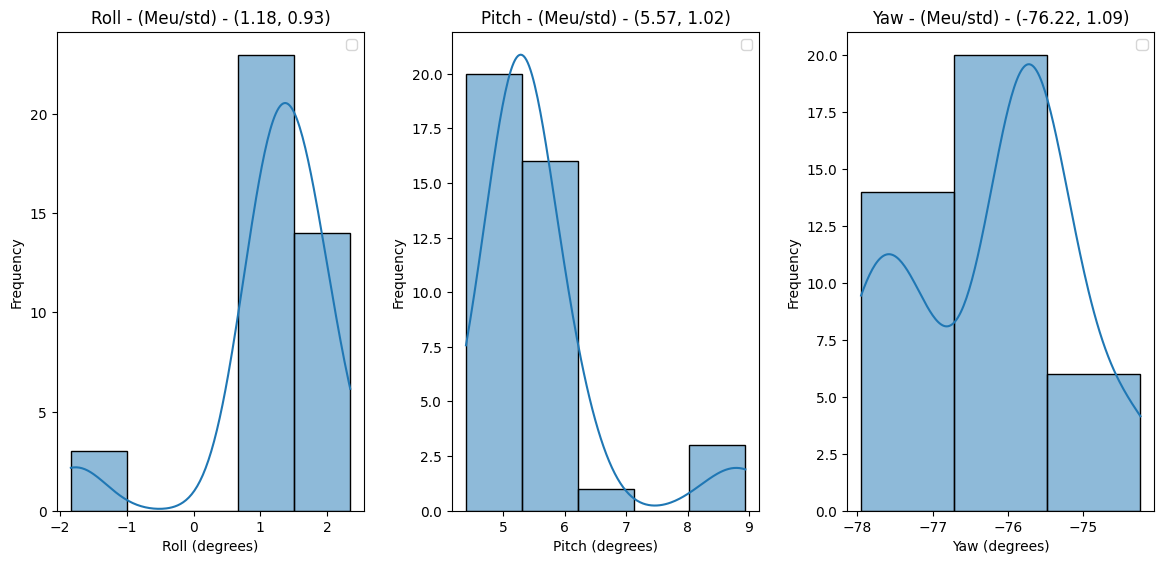

In [334]:
stability_data = calculate_stability(euler_data)

# print(stability_data)

In [ ]:


# Data to be plotted
data = [-7.22227, -7.22227, -6.755054, -6.8983, -7.855828, -7.880645, -8.394118, -8.394118, -7.233703, -7.233703, -7.444708, -7.705554, -7.705554, -7.820224, -7.727031]

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=10)

# Adding title and labels
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the plot
plt.show()